### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 09.01.2025 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [22]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 777 для воспроизводимости).

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=777
) # я поправил на 777 (мне не очень нравится 666), надеюсь, ничего страшного

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=777
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [26]:
%load_ext autoreload
%autoreload 2

from boosting import Boosting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [34]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)
#boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: total: 1.34 s
Wall time: 1.35 s
Train ROC-AUC 0.9872
Valid ROC-AUC 0.9342
Test ROC-AUC 0.9410


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

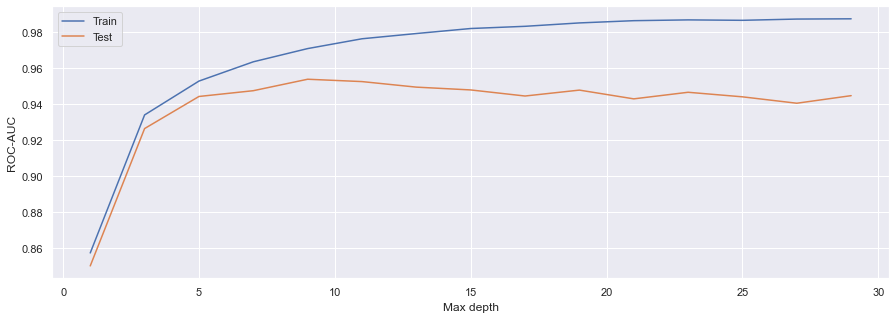

In [41]:
results = {
    "train": [],
    "test": [],
}

depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(base_model_params={'max_depth': depth, 'random_state':777})
    boosting.fit(x_train, y_train, x_train, y_train)

    results["train"].append(boosting.score(x_train, y_train))
    results["test"].append(boosting.score(x_test, y_test))

plt.figure(figsize=(15, 5))
plt.plot(depths, results["train"], label='Train')
plt.plot(depths, results["test"], label='Test')

plt.xlabel('Max depth')
plt.ylabel('ROC-AUC')

plt.legend()
plt.show()

### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Модель с глубиной где-то до 10 (7 или 8). Далее на тестовой выборе ухудшение показателей. Скорее всего при большой глубине модель все больше переобучается, показывая все хуже и хуже резлуьтаты

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [42]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

!pip install optuna



[notice] A new release of pip is available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import optuna
from sklearn.metrics import roc_auc_score

def foo(o):
    model = Boosting(base_model_params={
                        'max_depth': o.suggest_int('max_depth', 1, 30),
                        'random_state': 777
                    },
                    n_estimators=o.suggest_int('n_estimators', 1, 70),
                    learning_rate=o.suggest_float('learning_rate', 0.01, 0.7),
                    subsample=o.suggest_float('subsample', 0.5, 1.0),
                    early_stopping_rounds = o.suggest_int('early_stopping_rounds', 1, 70)
    )
    model.fit(x_train, y_train, x_valid, y_valid)
    pred = boosting.predict_proba(x_valid)
    return roc_auc_score(y_valid, pred[:, 1])

study = optuna.create_study()
study.optimize(foo, n_trials=50)
print(study.best_trial.params)

[I 2024-12-22 15:21:46,538] A new study created in memory with name: no-name-13dfbbfa-1126-4461-b62b-2bae58edd514
[I 2024-12-22 15:21:48,964] Trial 0 finished with value: 0.9400114801534881 and parameters: {'max_depth': 11, 'n_estimators': 21, 'learning_rate': 0.36903684697719924, 'subsample': 0.6514029976841242, 'early_stopping_rounds': 69}. Best is trial 0 with value: 0.9400114801534881.
[I 2024-12-22 15:22:02,210] Trial 1 finished with value: 0.9400114801534881 and parameters: {'max_depth': 21, 'n_estimators': 66, 'learning_rate': 0.1821822819724319, 'subsample': 0.5502992857911435, 'early_stopping_rounds': 41}. Best is trial 0 with value: 0.9400114801534881.
[I 2024-12-22 15:22:05,204] Trial 2 finished with value: 0.9400114801534881 and parameters: {'max_depth': 5, 'n_estimators': 55, 'learning_rate': 0.5031020126978354, 'subsample': 0.7077836515439258, 'early_stopping_rounds': 51}. Best is trial 0 with value: 0.9400114801534881.
[I 2024-12-22 15:22:16,071] Trial 3 finished with va

{'max_depth': 11, 'n_estimators': 21, 'learning_rate': 0.36903684697719924, 'subsample': 0.6514029976841242, 'early_stopping_rounds': 69}


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

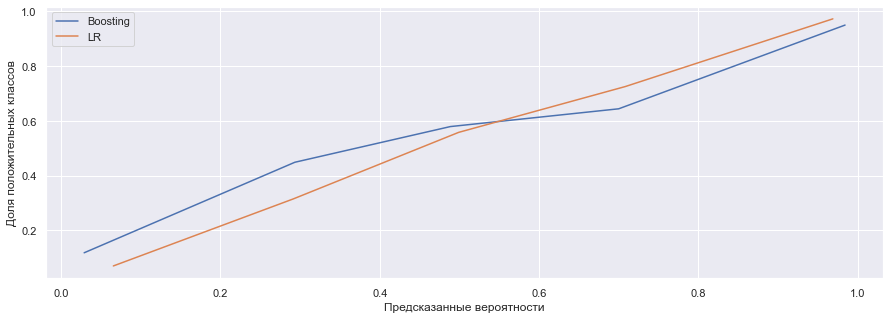

In [48]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

########### Boosting #############
boosting_model = Boosting(
    base_model_params={
        'max_depth': study.best_trial.params['max_depth'],
        'random_state': 777
    },
    n_estimators=study.best_trial.params['n_estimators'],
    learning_rate=study.best_trial.params['learning_rate'],
    subsample=study.best_trial.params['subsample'],
    early_stopping_rounds=study.best_trial.params['early_stopping_rounds']
)
boosting_model.fit(x_train, y_train, x_valid, y_valid)
boosting_score = roc_auc_score(y_test, boosting_model.predict_proba(x_test)[:, 1])
prob_boosting = boosting_model.predict_proba(x_test)[:, 1]

################ LR ###############
LR_model = LogisticRegression()
LR_model.fit(x_train, y_train)
prob_LR = LR_model.predict_proba(x_test)[:, 1]

################### Отрисуем ##############

plt.figure(figsize=(15, 5))

prob_boosting_true, prob_boosting_pred = calibration_curve(y_test, prob_boosting)
plt.plot(prob_boosting_pred, prob_boosting_true, label='Boosting')

prob_true_log_reg, prob_pred_log_reg = calibration_curve(y_test, prob_LR)
plt.plot(prob_pred_log_reg, prob_true_log_reg, label='LR')

plt.xlabel('Предсказанные вероятности')
plt.ylabel('Доля положительных классов')

plt.legend()
plt.show()


Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

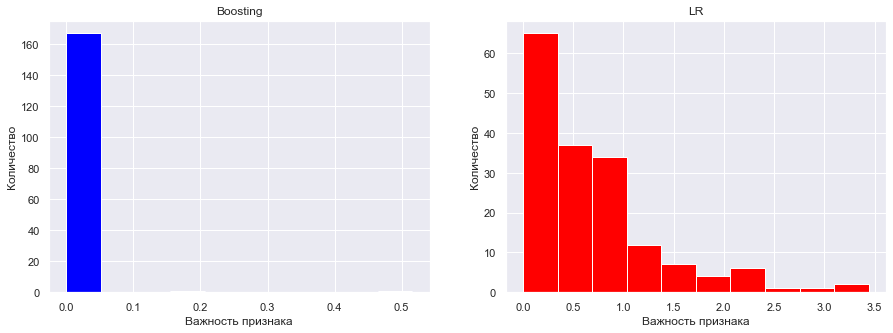

In [62]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

plt.figure(figsize=(15, 5))

########### Boosting ##############

plt.subplot(1, 2, 1)
plt.hist(boosting_model.feature_importances_, color='blue')
plt.title('Boosting')
plt.xlabel('Важность признака')
plt.ylabel('Количество')
plt.grid(True)

################ LR ###############

plt.subplot(1, 2, 2)
plt.hist(np.abs(LR_model.coef_[0]), color='red')
plt.title('LR')
plt.xlabel('Важность признака')
plt.ylabel('Количество')
plt.grid(True)

plt.show()

Как-то непонятно, воспользуюсь логарифмом

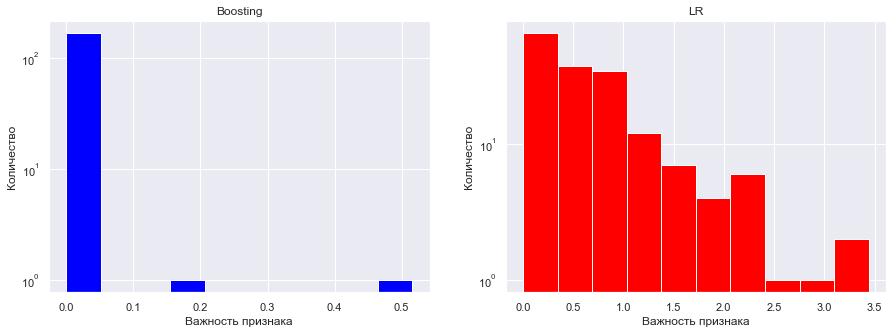

In [63]:
plt.figure(figsize=(15, 5))

########### Boosting #############

plt.subplot(1, 2, 1)
plt.hist(boosting_model.feature_importances_, color='blue', log=True)
plt.title('Boosting')
plt.xlabel('Важность признака')
plt.ylabel('Количество')
plt.grid(True)

################ LR ###############

plt.subplot(1, 2, 2)
plt.hist(np.abs(LR_model.coef_[0]), color='red', log=True)
plt.title('LR')
plt.xlabel('Важность признака')
plt.ylabel('Количество')
plt.grid(True)

plt.show()

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [65]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ


new_model_boosting = Boosting(
    base_model_params={
        'max_depth': study.best_trial.params['max_depth'],
        'random_state': 777
    },
    n_estimators=study.best_trial.params['n_estimators'],
    learning_rate=study.best_trial.params['learning_rate'],
    subsample=study.best_trial.params['subsample'],
    early_stopping_rounds=study.best_trial.params['early_stopping_rounds']
)


########### Немного отфильтурем feature_importances ################
quantile = np.quantile(boosting_model.feature_importances_, 0.15)
filtered_features = np.where(boosting_model.feature_importances_ >= quantile)[0]

########### Обучим и сравним #############
new_model_boosting.fit(
    x_train[:, filtered_features], y_train,
    x_valid[:, filtered_features], y_valid
)

new_score = roc_auc_score(
    y_test,
    new_model_boosting.predict_proba(x_test[:, filtered_features])[:, 1]
)

print(boosting_score, new_score)
print(f'Delta: {abs(boosting_score - new_score)}')


0.9551510656016287 0.9552130800566345
Delta: 6.201445500586544e-05


## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [ ]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ



## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [ ]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ



Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
